# King County House Sales - Regularised Regression in R

This tutorial shows how to fit a linear regression and regularised linear regression to the Seattle House Prices (King County).

Information about this dataset is available at  https://www.kaggle.com/datasets/harlfoxem/housesalesprediction.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/OpenActTextDev/ActuarialRegression/blob/main/Notebooks/HousePriceRegularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>


## 1. Load required packages
We start by loading the necessary packages for data manipulation and regularised regression. If `glmnet` is not installed, install it first. This might take a few minutes.


In [1]:
library(tidyverse)       # for data manipulation and plotting
install.packages("glmnet")  # ensure glmnet is available
library(glmnet)          # for ridge and lasso regression

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-10



## 2. Load and clean data
Read the housing dataset from GitHub.


In [2]:
# read_csv() is used to load CSV data from a URL
KCdata <- read_csv("https://raw.githubusercontent.com/OpenActTextDev/ActuarialRegression/refs/heads/main/CourseCSVData/kc_house_data.csv")

Rows: 21613 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): id
dbl  (19): price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterf...
dttm  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Let explore the variables in the data.

In [3]:
str(KCdata)

spc_tbl_ [21,613 × 21] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ id           : chr [1:21613] "7129300520" "6414100192" "5631500400" "2487200875" ...
 $ date         : POSIXct[1:21613], format: "2014-10-13" "2014-12-09" ...
 $ price        : num [1:21613] 221900 538000 180000 604000 510000 ...
 $ bedrooms     : num [1:21613] 3 3 2 4 3 4 3 3 3 3 ...
 $ bathrooms    : num [1:21613] 1 2.25 1 3 2 4.5 2.25 1.5 1 2.5 ...
 $ sqft_living  : num [1:21613] 1180 2570 770 1960 1680 ...
 $ sqft_lot     : num [1:21613] 5650 7242 10000 5000 8080 ...
 $ floors       : num [1:21613] 1 2 1 1 1 1 2 1 1 2 ...
 $ waterfront   : num [1:21613] 0 0 0 0 0 0 0 0 0 0 ...
 $ view         : num [1:21613] 0 0 0 0 0 0 0 0 0 0 ...
 $ condition    : num [1:21613] 3 3 3 5 3 3 3 3 3 3 ...
 $ grade        : num [1:21613] 7 7 6 7 8 11 7 7 7 7 ...
 $ sqft_above   : num [1:21613] 1180 2170 770 1050 1680 ...
 $ sqft_basement: num [1:21613] 0 400 0 910 0 1530 0 0 730 0 ...
 $ yr_built     : num [1:21613] 1955 1951 1933 1965 

Remove irrelevant or redundant variables. Then, convert appropriate variables to factors.

In [4]:
KCdata <- KCdata %>%
  select(-id, -date, -zipcode, -lat, -long,
         -grade, -yr_renovated, -sqft_basement)

KCdata <- KCdata %>%
  mutate(
    waterfront = as.factor(waterfront),
    view = as.factor(view),
    condition = as.factor(condition)
  )

**Reflection:** What types of variables are most appropriate to convert into factors? Why?


## 3. Exploratory data visualisation
Visualise how the price varies with key variables like living area, bathrooms, and waterfront view.


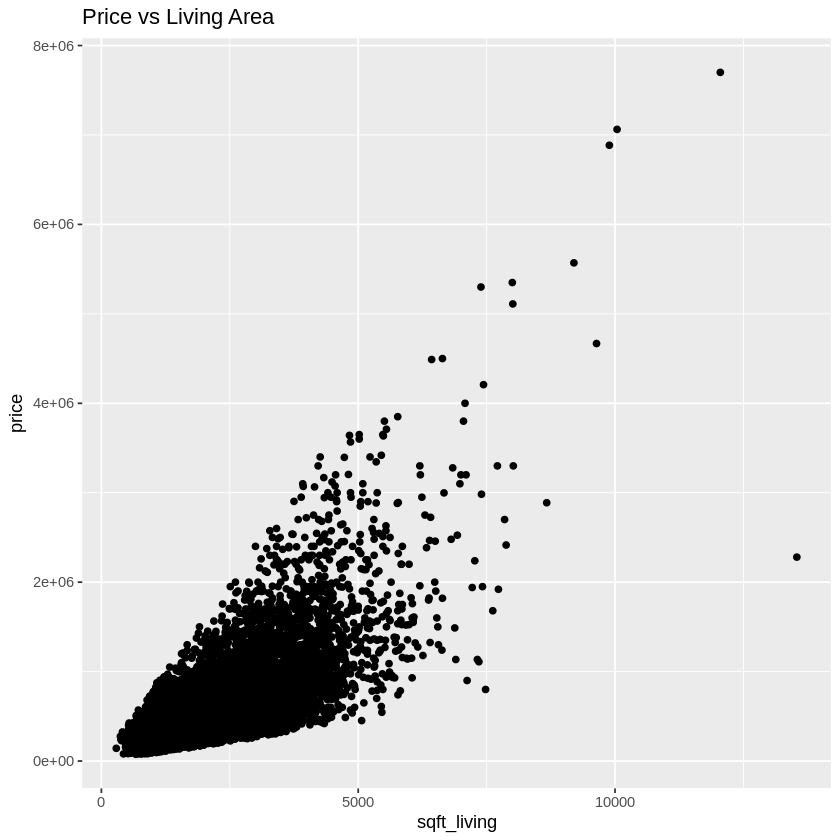

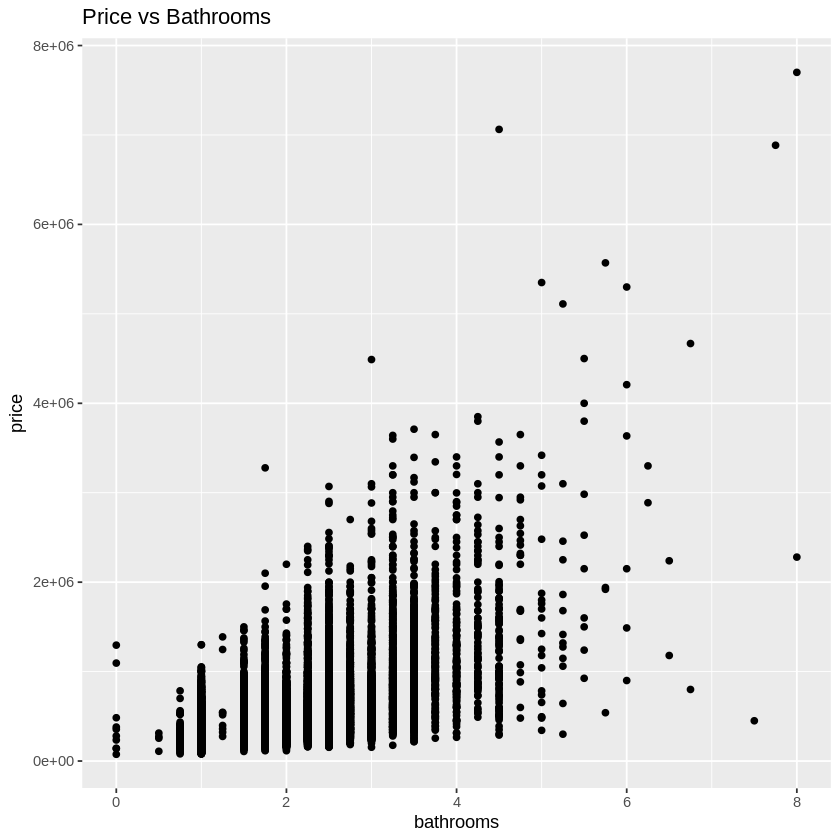

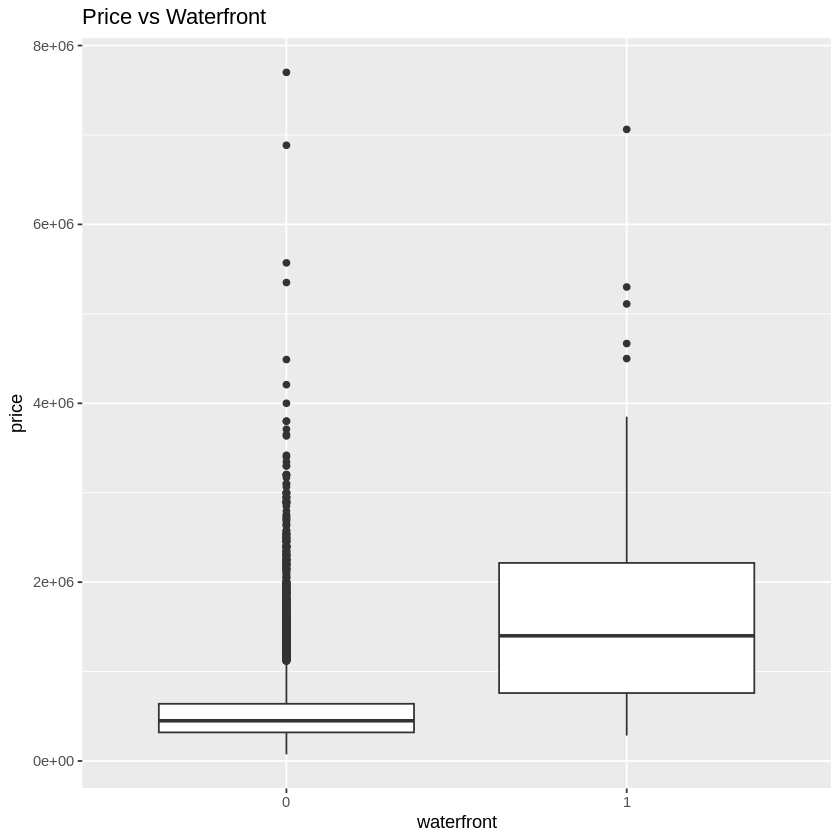

In [5]:
ggplot(KCdata) +
  geom_point(aes(x = sqft_living, y = price)) +
  labs(title = "Price vs Living Area")

ggplot(KCdata) +
  geom_point(aes(x = bathrooms, y = price)) +
  labs(title = "Price vs Bathrooms")

ggplot(KCdata, aes(x = waterfront, y = price)) +
  geom_boxplot() +
  labs(title = "Price vs Waterfront")

**Try this:** Plot `price` vs `condition` using a boxplot. What do you observe?





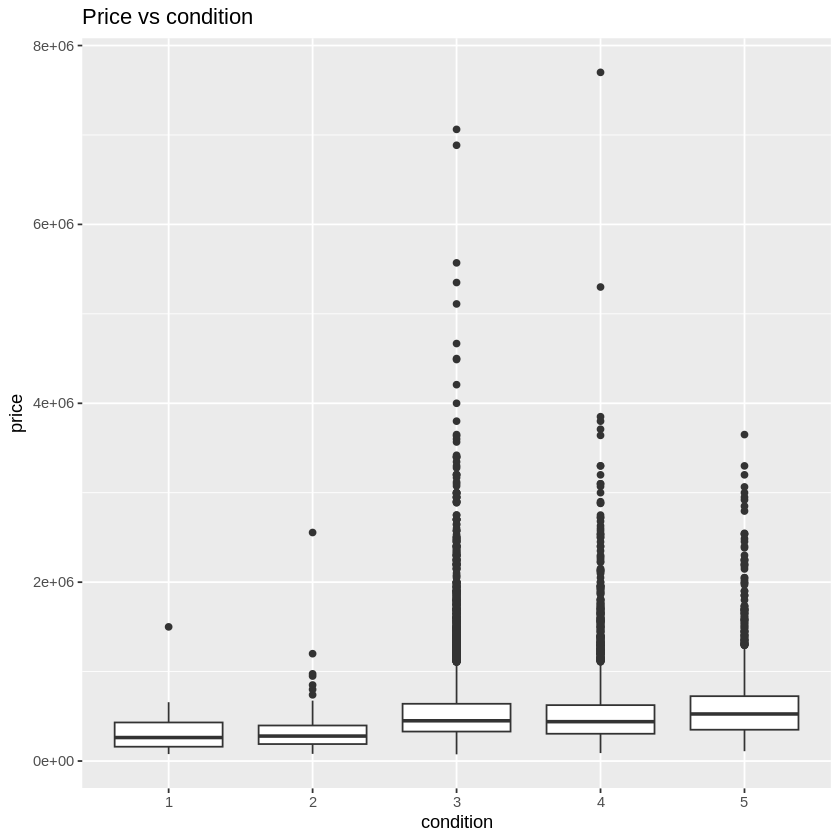

In [6]:
ggplot(KCdata, aes(x = condition, y = price)) +
  geom_boxplot() +
  labs(title = "Price vs condition")

## 4. Train/test split (80/20)
Split the dataset into training and test subsets.


In [7]:
set.seed(123) #ensures reproducibility of the random sample
n <- nrow(KCdata) # get number of rows
indexTrain <- sample(1:n, round(n * 0.8))  # randomly select 80% for training
KCdataTrain <- KCdata[indexTrain, ]
KCdataTest <- KCdata[-indexTrain, ]

## 5. Fit linear models
Fit two linear models: a simple one using only `sqft_living`, and a full model using all predictors.


In [8]:
lmArea <- lm(price ~ sqft_living, data = KCdataTrain)
summary(lmArea)

lmAll <- lm(price ~ ., data = KCdataTrain)
summary(lmAll)


Call:
lm(formula = price ~ sqft_living, data = KCdataTrain)

Residuals:
     Min       1Q   Median       3Q      Max 
-1465693  -147174   -24984   106153  4371080 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -41627.883   4889.428  -8.514   <2e-16 ***
sqft_living    279.714      2.151 130.055   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 259900 on 17288 degrees of freedom
Multiple R-squared:  0.4945,	Adjusted R-squared:  0.4945 
F-statistic: 1.691e+04 on 1 and 17288 DF,  p-value: < 2.2e-16



Call:
lm(formula = price ~ ., data = KCdataTrain)

Residuals:
     Min       1Q   Median       3Q      Max 
-1414666  -122159   -12037    96831  4132788 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    5.857e+06  1.591e+05  36.819  < 2e-16 ***
bedrooms      -5.242e+04  2.376e+03 -22.063  < 2e-16 ***
bathrooms      6.559e+04  4.103e+03  15.986  < 2e-16 ***
sqft_living    2.137e+02  5.413e+00  39.483  < 2e-16 ***
sqft_lot      -3.902e-03  6.255e-02  -0.062 0.950250    
floors         5.330e+04  4.465e+03  11.937  < 2e-16 ***
waterfront1    4.522e+05  2.446e+04  18.491  < 2e-16 ***
view1          1.152e+05  1.416e+04   8.132 4.49e-16 ***
view2          7.212e+04  8.652e+03   8.336  < 2e-16 ***
view3          1.208e+05  1.189e+04  10.166  < 2e-16 ***
view4          3.103e+05  1.785e+04  17.381  < 2e-16 ***
condition2     1.049e+05  5.592e+04   1.876 0.060689 .  
condition3     1.394e+05  5.249e+04   2.655 0.007942 ** 
condition4     1.530e+05  5.250e

**Challenge:** Try fitting a linear model using only `bathrooms`, `view`, and `condition`. How does the adjusted R$^2$ compare?


In [9]:
lmMultiple <- lm(price ~ bathrooms + view + condition, data = KCdataTrain)
summary(lmMultiple)


Call:
lm(formula = price ~ bathrooms + view + condition, data = KCdataTrain)

Residuals:
     Min       1Q   Median       3Q      Max 
-1235680  -169188   -32080   113566  5813907 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -45148      65892  -0.685    0.493    
bathrooms     230232       2958  77.824   <2e-16 ***
view1         243761      17621  13.834   <2e-16 ***
view2         213824      10620  20.134   <2e-16 ***
view3         314213      14531  21.624   <2e-16 ***
view4         755562      17879  42.260   <2e-16 ***
condition2     28134      70262   0.400    0.689    
condition3     43871      65895   0.666    0.506    
condition4     95821      65940   1.453    0.146    
condition5    146585      66265   2.212    0.027 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 286600 on 17280 degrees of freedom
Multiple R-squared:  0.3856,	Adjusted R-squared:  0.3853 
F-statistic:  1205 on 9 and 17280 

## 6. Evaluate models
Calculate the Mean Squared Error (MSE) on training and test datasets for both models.


In [10]:
yhat_lmArea <- fitted(lmArea)
lmAreaMSE_tr <- mean((yhat_lmArea - KCdataTrain$price)^2)
yhat_lmAll <- fitted(lmAll)
lmAllMSE_tr <- mean((yhat_lmAll - KCdataTrain$price)^2)

yhat_lmArea_test <- predict(lmArea, newdata = KCdataTest)
lmAreaMSE_te <- mean((yhat_lmArea_test - KCdataTest$price)^2)
yhat_lmAll_test <- predict(lmAll, newdata = KCdataTest)
lmAllMSE_te <- mean((yhat_lmAll_test - KCdataTest$price)^2)

lmAreaMSE_tr
lmAllMSE_tr
lmAreaMSE_te
lmAllMSE_te

[1] 67550766176

[1] 51917007941

[1] 71556509669

[1] 55061706579

**Reflect:** The training MSE of the multiple regression model would always be smaller that the treaining MSE of the simple model (Why?).  
Why might the multiple regression model have a lower training RSS but a higher test RSS than the simple model?

## 7. Ridge and Lasso Regression
Create the model matrix and fit both ridge and lasso regression using `glmnet`.


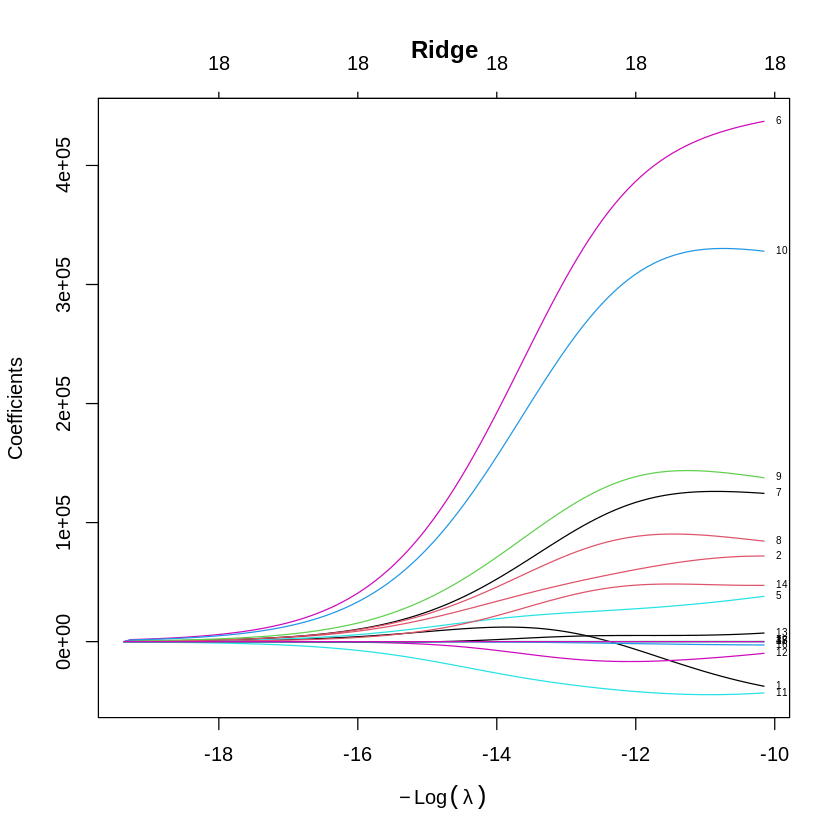

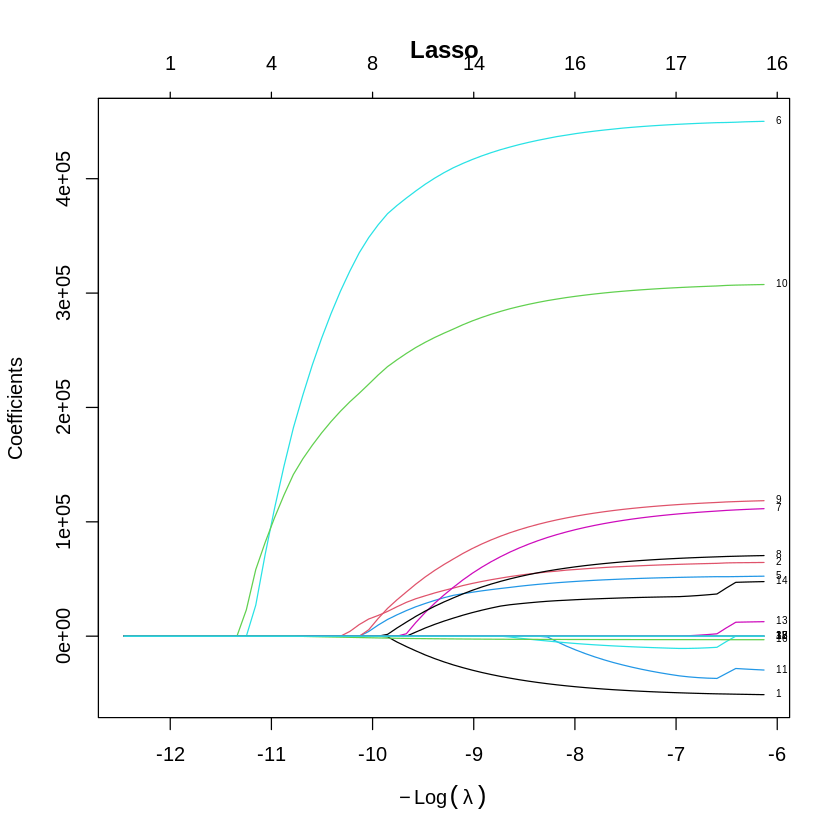

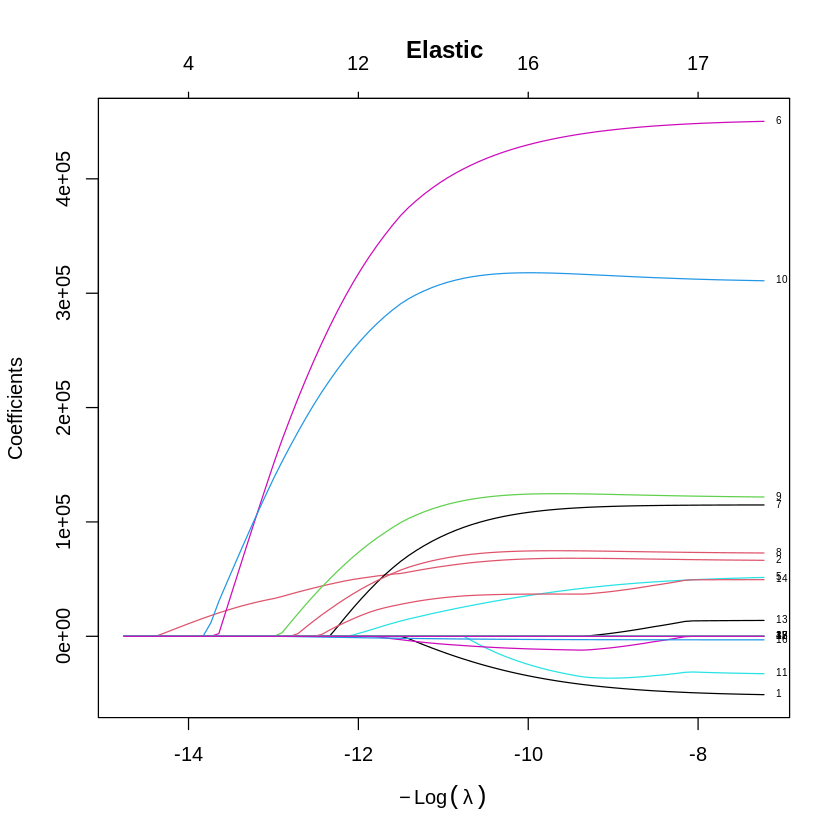

In [17]:
X <- model.matrix(lmAll)[, -1]   # model.matrix creates the X matrix (removing intercept column)
Y <- KCdataTrain$price

ridge_model <- glmnet(X, Y, alpha = 0) # alpha = 0 => ridge regression
lasso_model <- glmnet(X, Y, alpha = 1) # alpha = 1 => lasso regression
elastic_model <- glmnet(X, Y, alpha = 0.1) # alpha = 0.5 => ambos


plot(ridge_model, xvar = "lambda", label = TRUE, main = "Ridge")
plot(lasso_model, xvar = "lambda", label = TRUE, main = "Lasso")
plot(elastic_model, xvar = "lambda", label = TRUE, main = "Elastic")


**Practice question:** What effect does increasing lambda have on the coefficients in ridge and lasso models?


## 8. Cross-validation for lambda selection
Use cross-validation to find the optimal `lambda` for both ridge and lasso.

**Think about this:** Why do we use cross-validation instead of just picking a lambda by eye from the coefficient plot?



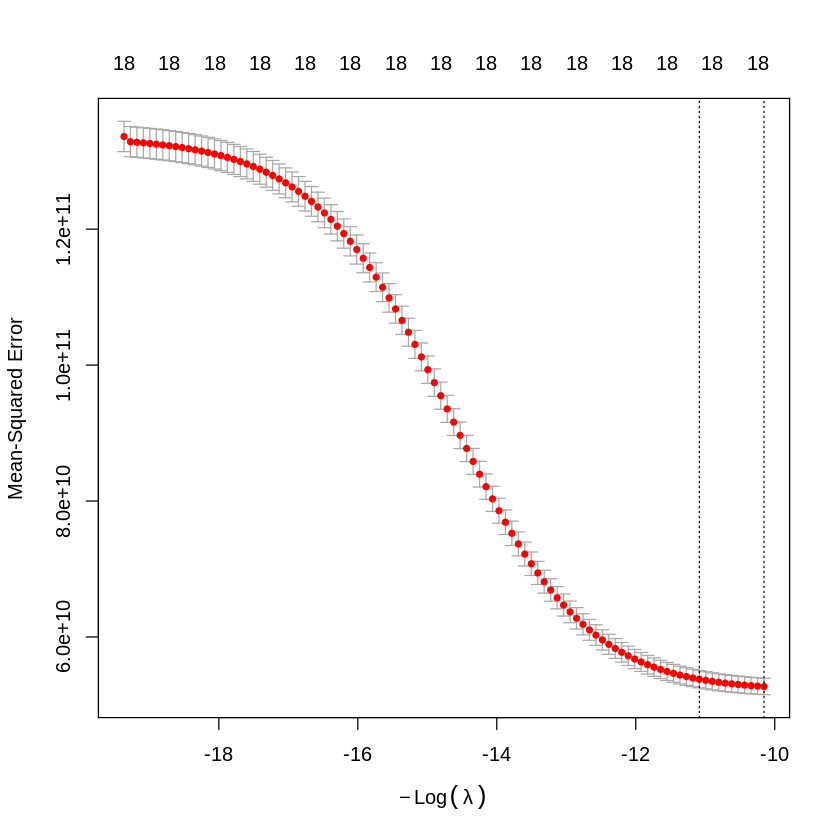

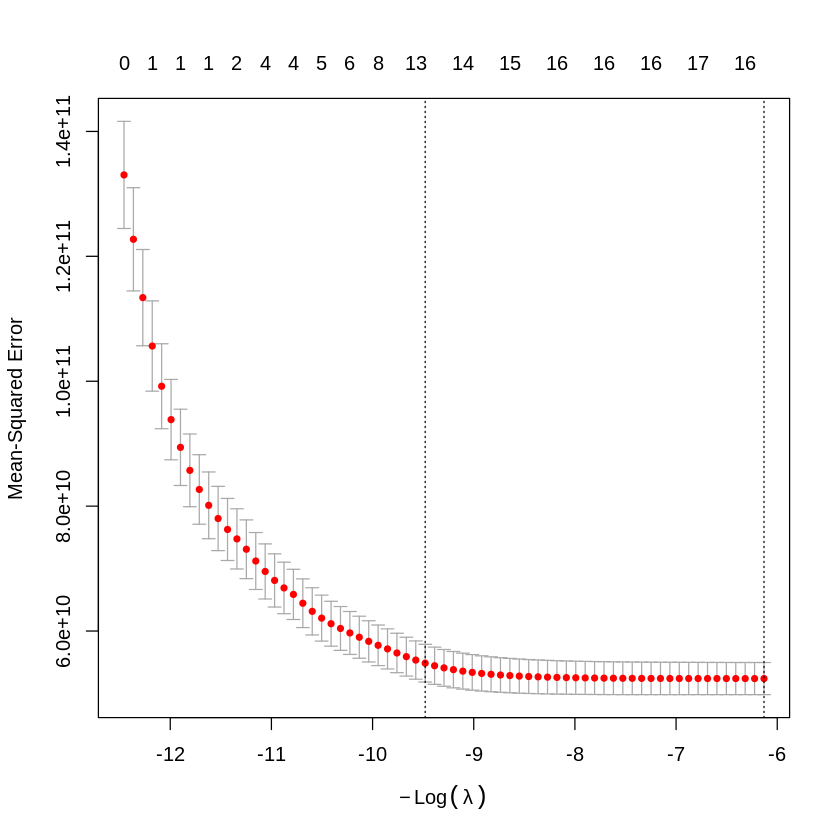

In [18]:
cv_ridge <- cv.glmnet(X, Y, alpha = 0, type.measure = "mse") # 10-fold CV for ridge
#Note the number of folds is set to 10 by default.
#It can be changed by setting the `nfolds` argument
cv_lasso <- cv.glmnet(X, Y, alpha = 1, type.measure = "mse") # 10-fold CV for lasso

plot(cv_ridge)
plot(cv_lasso)

We can now find the value of labmda that minimises the cross-validation MSE and refit the models.

In [19]:
ridge_lambda_opt <- cv_ridge$lambda.min
lasso_lambda_opt <- cv_lasso$lambda.min

ridge_final <- glmnet(X, Y, alpha = 0, lambda = ridge_lambda_opt)
lasso_final <- glmnet(X, Y, alpha = 1, lambda = lasso_lambda_opt)

## 9. Evaluate Ridge and Lasso on test data
Predict house prices using the final models and calculate MSE.


In [20]:
newx_test <- model.matrix(price ~ ., data = KCdataTest)[, -1]

yhat_ridge_test <- predict(ridge_final, newx = newx_test)
yhat_lasso_test <- predict(lasso_final, newx = newx_test)

ridgeMSE_te <- mean((yhat_ridge_test - KCdataTest$price)^2)
lassoMSE_te <- mean((yhat_lasso_test - KCdataTest$price)^2)

## 10. Compare model performance
Print and compare MSEs across all models.


In [21]:
cat("\n\nModel Comparison (Test MSE):\n")
cat("Simple Linear (sqft_living):", lmAreaMSE_te, "\n")
cat("Multiple Linear:", lmAllMSE_te, "\n")
cat("Ridge Regression:", ridgeMSE_te, "\n")
cat("Lasso Regression:", lassoMSE_te, "\n")



Model Comparison (Test MSE):
Simple Linear (sqft_living): 71556509669 
Multiple Linear: 55061706579 
Ridge Regression: 56051083558 
Lasso Regression: 55063199765 


**Reflection:** Which model performed best? Which would you use in practice, and why?

#  Challenge: Try a log-transformation of the target (do it after the lab)

Let's explore the distribution of the response variable `price`.

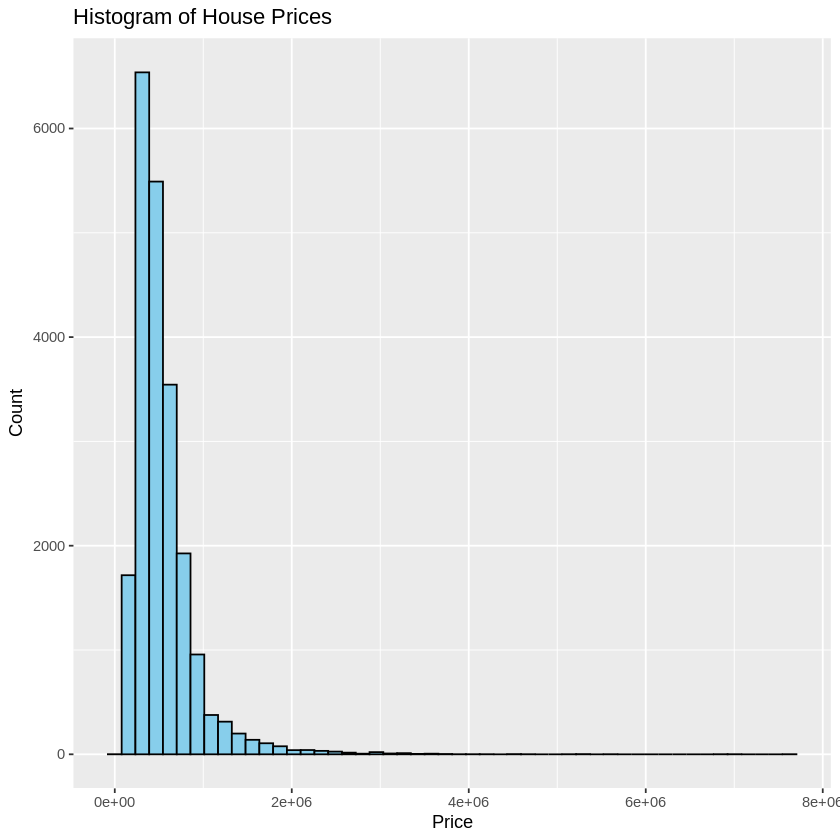

In [22]:
ggplot(KCdata, aes(x = price)) +
  geom_histogram(bins = 50, fill = "skyblue", color = "black") +
  labs(title = "Histogram of House Prices", x = "Price", y = "Count")

The histogram shows that price is **right-skewed**, meaning there are a few very high values. This can violate the assumptions of linear models and inflate error.

It is often better to model the logarithm of price instead of price directly when the distribution is skewed.

### Task for students:
1. Recreate the models (simple, multiple, ridge, lasso), but with `log(price)` as the response variable.
2. Compare the test MSEs for these log-models versus the original models.
3. Reflect: Which performed better and why?

**Hint:** You can use:

In [ ]:
lm(log(price) ~ sqft_living, data = KCdataTrain)

And update the response to:

In [ ]:
Y_log <- log(KCdataTrain$price)

when using `glmnet()`.

In [23]:
lmArea_log <- lm(log(price) ~ sqft_living, data = KCdataTrain)
summary(lmArea)

lmAll_log <- lm(log(price) ~ ., data = KCdataTrain)
summary(lmAll)


Call:
lm(formula = price ~ sqft_living, data = KCdataTrain)

Residuals:
     Min       1Q   Median       3Q      Max 
-1465693  -147174   -24984   106153  4371080 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -41627.883   4889.428  -8.514   <2e-16 ***
sqft_living    279.714      2.151 130.055   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 259900 on 17288 degrees of freedom
Multiple R-squared:  0.4945,	Adjusted R-squared:  0.4945 
F-statistic: 1.691e+04 on 1 and 17288 DF,  p-value: < 2.2e-16



Call:
lm(formula = price ~ ., data = KCdataTrain)

Residuals:
     Min       1Q   Median       3Q      Max 
-1414666  -122159   -12037    96831  4132788 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    5.857e+06  1.591e+05  36.819  < 2e-16 ***
bedrooms      -5.242e+04  2.376e+03 -22.063  < 2e-16 ***
bathrooms      6.559e+04  4.103e+03  15.986  < 2e-16 ***
sqft_living    2.137e+02  5.413e+00  39.483  < 2e-16 ***
sqft_lot      -3.902e-03  6.255e-02  -0.062 0.950250    
floors         5.330e+04  4.465e+03  11.937  < 2e-16 ***
waterfront1    4.522e+05  2.446e+04  18.491  < 2e-16 ***
view1          1.152e+05  1.416e+04   8.132 4.49e-16 ***
view2          7.212e+04  8.652e+03   8.336  < 2e-16 ***
view3          1.208e+05  1.189e+04  10.166  < 2e-16 ***
view4          3.103e+05  1.785e+04  17.381  < 2e-16 ***
condition2     1.049e+05  5.592e+04   1.876 0.060689 .  
condition3     1.394e+05  5.249e+04   2.655 0.007942 ** 
condition4     1.530e+05  5.250e

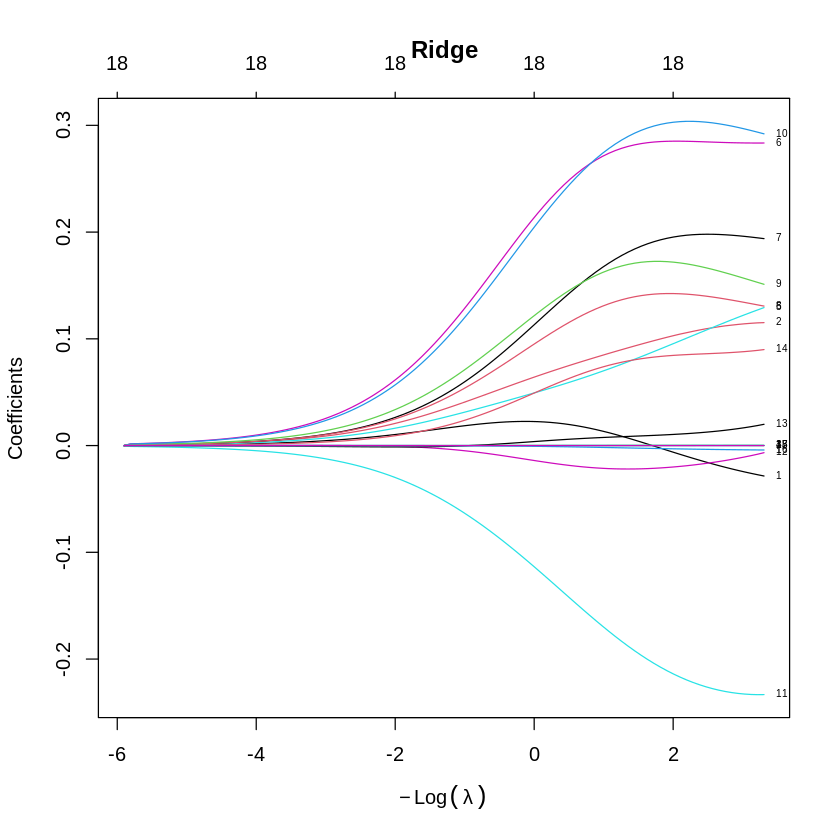

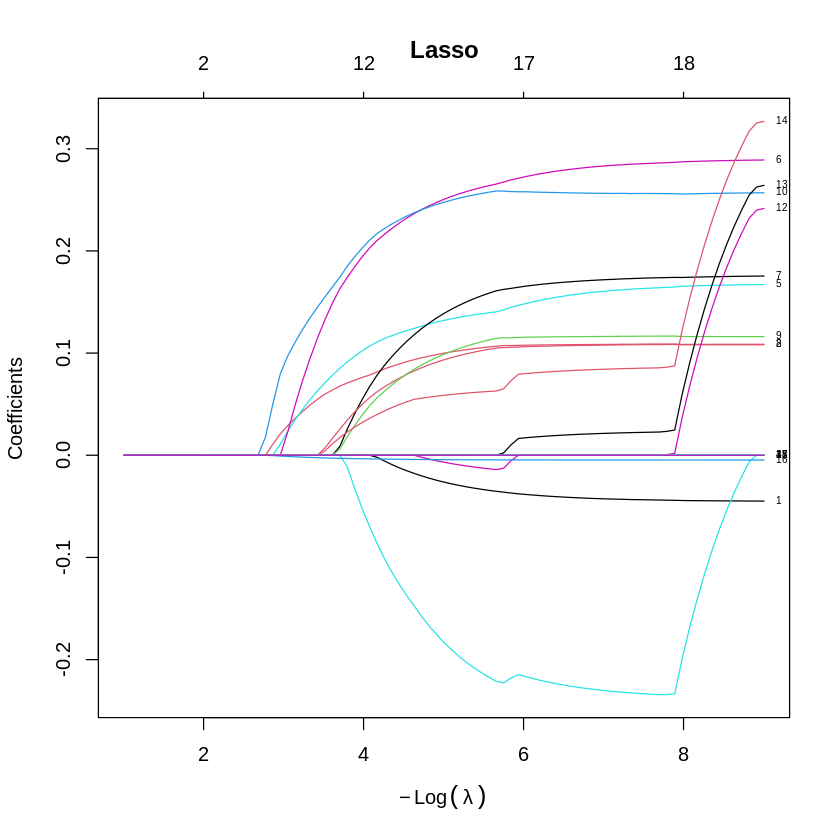

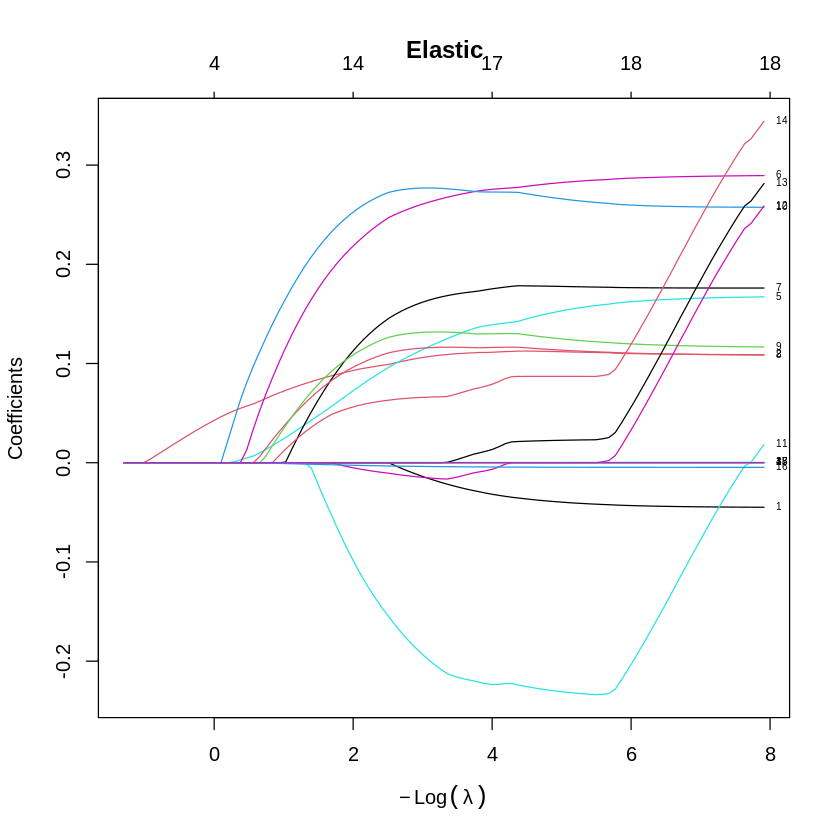

In [24]:
X_log <- model.matrix(lmAll_log)[, -1]   # model.matrix creates the X matrix (removing intercept column)
Y_log <- log(KCdataTrain$price)

ridge_model_log <- glmnet(X_log, Y_log, alpha = 0) # alpha = 0 => ridge regression
lasso_model_log <- glmnet(X_log, Y_log, alpha = 1) # alpha = 1 => lasso regression
elastic_model_log <- glmnet(X_log, Y_log, alpha = 0.1) # alpha = 0.5 => ambos

plot(ridge_model_log, xvar = "lambda", label = TRUE, main = "Ridge")
plot(lasso_model_log, xvar = "lambda", label = TRUE, main = "Lasso")
plot(elastic_model_log, xvar = "lambda", label = TRUE, main = "Elastic")

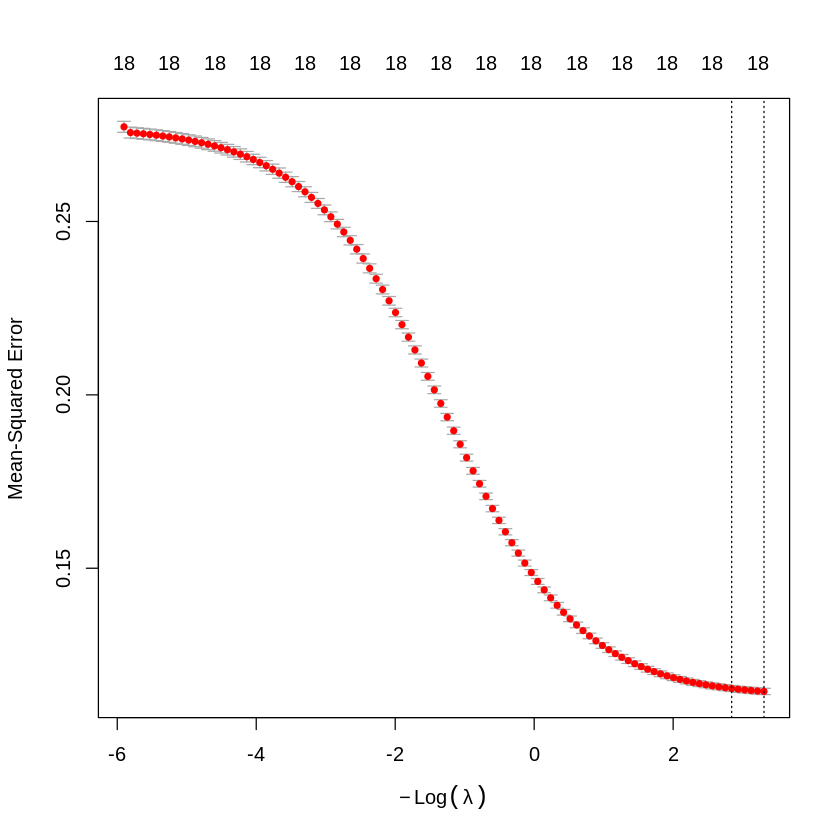

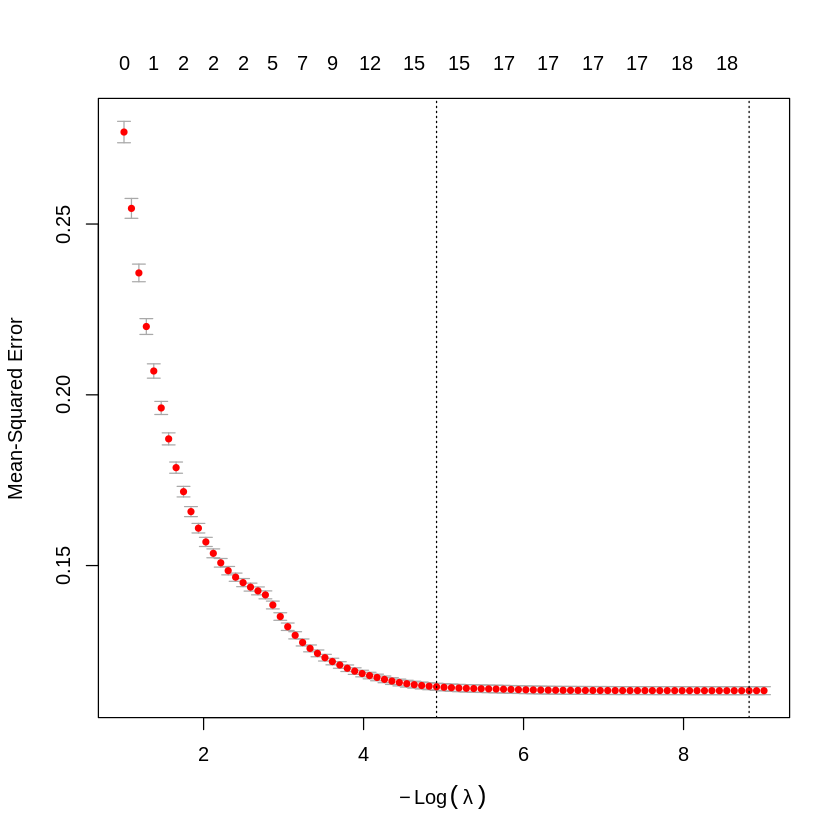

In [25]:
cv_ridge_log <- cv.glmnet(X_log, Y_log, alpha = 0, type.measure = "mse") # 10-fold CV for ridge
#Note the number of folds is set to 10 by default.
#It can be changed by setting the `nfolds` argument
cv_lasso_log <- cv.glmnet(X_log, Y_log, alpha = 1, type.measure = "mse") # 10-fold CV for lasso

plot(cv_ridge_log)
plot(cv_lasso_log)

In [29]:
ridge_lambda_opt_log <- cv_ridge_log$lambda.min
lasso_lambda_opt_log <- cv_lasso_log$lambda.min

ridge_final_log <- glmnet(X_log, Y_log, alpha = 0, lambda = ridge_lambda_opt_log)
lasso_final_log <- glmnet(X_log, Y_log, alpha = 1, lambda = lasso_lambda_opt_log)

In [30]:
newx_test_log <- model.matrix(log(price) ~ ., data = KCdataTest)[, -1]

yhat_ridge_test_log <- predict(ridge_final_log, newx = newx_test_log)
yhat_lasso_test_log <- predict(lasso_final_log, newx = newx_test_log)

ridgeMSE_te_log <- mean((yhat_ridge_test_log - log(KCdataTrain$price))^2)
lassoMSE_te_log <- mean((yhat_lasso_test_log - log(KCdataTrain$price))^2)

Warning message in yhat_ridge_test_log - log(KCdataTrain$price):
“longer object length is not a multiple of shorter object length”


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'mean': dims [product 4323] do not match the length of object [17290]


In [ ]:
cat("\n\nModel Comparison (Test MSE):\n")
cat("Simple Linear (sqft_living):", lmAreaMSE_te, "\n")
cat("Multiple Linear:", lmAllMSE_te, "\n")
cat("Ridge Regression:", ridgeMSE_te, "\n")
cat("Lasso Regression:", lassoMSE_te, "\n")